In [23]:
from autoencoder import AutoEncoder
import pandas as pd
import numpy as np

In [24]:
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch import nn
from scipy.sparse import coo_matrix

In [25]:
import matplotlib.pyplot as plt

In [26]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [27]:
def mask_sample(tensor: torch.Tensor, mask_fraction: float, device: torch.device):
    tensor = tensor.to(device)
    masked_tensor = tensor.clone()

    # Identify non-zero elements in the tensor
    non_zero_indices = (tensor != 0).nonzero(as_tuple=False)

    # Determine the number of elements to mask
    num_non_zeros = non_zero_indices.size(0)
    num_to_mask = int(mask_fraction * num_non_zeros)

    if num_to_mask > 0:
        # Randomly select indices to mask
        mask_indices = torch.randperm(num_non_zeros)[:num_to_mask]

        # Apply the mask
        masked_tensor[non_zero_indices[mask_indices, 0], non_zero_indices[mask_indices, 1]] = 0

    return masked_tensor

In [1]:
def test_sample_model(model: AutoEncoder, masked_test, sample:pd.DataFrame, device: torch.device):
    model.eval()
    sample_coo = coo_matrix(sample.values)
    
    # Convert the COO matrix to a dense tensor
    sample_tensor = torch.tensor(sample_coo.toarray(), dtype=torch.float32, device=device)

    
    # Test the model on each row of the sample
    # tested = sample.apply(lambda row: mask_test_model(model, 0.2, torch.tensor(row.to_numpy(), dtype=torch.float32, device=device), device)[0], axis=1)
    masked_test = mask_sample(sample_tensor, 0.2, device)
    

    tested_df = pd.DataFrame(index=sample.index, columns=sample.columns)

    result = model(masked_test)

    for i, j in zip(sample_coo.row, sample_coo.col):
        tested_df.iloc[i, j] = result[i, j].item()

    # Calculate the Frobenius norm of the difference
    # calculate the rmse
    
    # loss = linalg.norm(sample.to_numpy() - tested.to_numpy().T, ord='fro')
    mse = np.mean((sample.to_numpy() - result.cpu().detach().numpy())**2)
    loss = np.sqrt(mse)
    
    return loss, tested_df.T, sample

NameError: name 'AutoEncoder' is not defined

In [29]:
np.random.seed(42)
torch.manual_seed(42)

# Create a user-item interaction matrix (100 users, 50 items) with sparsity
num_users = 10000
num_items = 500
interaction_matrix = np.random.randint(0, 6, size=(num_users, num_items))  # Random interactions from 0 to 5

# Introduce sparsity by setting a high percentage of interactions to 0
sparsity = 0.8  # 80% of the interactions will be set to 0
mask = np.random.rand(*interaction_matrix.shape) < sparsity
interaction_matrix[mask] = 0
interaction_matrix = pd.DataFrame(interaction_matrix, index=range(interaction_matrix.shape[0]), columns=range(interaction_matrix.shape[1]))

In [30]:
coo = coo_matrix(interaction_matrix, (num_users, num_items))
dense_matrix = torch.tensor(coo.toarray(), dtype=torch.float32).to(device)
dataset = TensorDataset(dense_matrix)
bottleneck_size = 32
batch_size = 128
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [31]:
model = AutoEncoder(coo.shape[1], bottleneck_size, device=device).to(device)

Epoch [1/1000], Loss: 1.6104
Epoch [2/1000], Loss: 1.5616
Epoch [3/1000], Loss: 1.5416
Epoch [4/1000], Loss: 1.5242
Epoch [5/1000], Loss: 1.5112
Epoch [6/1000], Loss: 1.5018
Epoch [7/1000], Loss: 1.4950
Epoch [8/1000], Loss: 1.4901
Epoch [9/1000], Loss: 1.4873
Epoch [10/1000], Loss: 1.4827
Epoch [11/1000], Loss: 1.4786
Epoch [12/1000], Loss: 1.4764
Epoch [13/1000], Loss: 1.4720
Epoch [14/1000], Loss: 1.4681
Epoch [15/1000], Loss: 1.4650
Epoch [16/1000], Loss: 1.4621
Epoch [17/1000], Loss: 1.4599
Epoch [18/1000], Loss: 1.4576
Epoch [19/1000], Loss: 1.4567
Epoch [20/1000], Loss: 1.4556
Epoch [21/1000], Loss: 1.4549
Epoch [22/1000], Loss: 1.4538
Epoch [23/1000], Loss: 1.4534
Epoch [24/1000], Loss: 1.4526
Epoch [25/1000], Loss: 1.4526
Epoch [26/1000], Loss: 1.4519
Epoch [27/1000], Loss: 1.4514
Epoch [28/1000], Loss: 1.4507
Epoch [29/1000], Loss: 1.4504
Epoch [30/1000], Loss: 1.4504
Epoch [31/1000], Loss: 1.4476
Epoch [32/1000], Loss: 1.4463
Epoch [33/1000], Loss: 1.4457
Epoch [34/1000], Lo

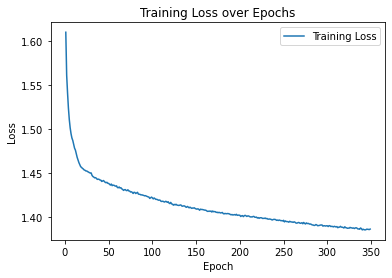

In [32]:
# Train the model
epochs, epoch_losses = model.fit(train_loader, n_epochs=1000, lr=0.001, patience=10)

# Plot the training loss over epochs
plt.plot(epochs, epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

In [33]:
res = test_sample_model(model, interaction_matrix, device)
res[1]

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.722846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.622437,NaN,NaN,0.632438,NaN,NaN,0.652444,0.359875,NaN,NaN
1,NaN,0.79467,NaN,0.765655,0.794303,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.632058,NaN,NaN,0.692446,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,0.300264,NaN,NaN,NaN,NaN,0.423617,0.670599,...,NaN,NaN,0.350484,NaN,1.378193,NaN,NaN,NaN,0.402952,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.183549,NaN,...,NaN,NaN,0.111399,0.690187,0.310016,NaN,NaN,0.142618,NaN,1.316049
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.253203,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.419519,NaN,NaN,NaN,0.182937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,NaN,0.471794,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.016872,NaN,NaN
496,NaN,0.643406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.423112,...,NaN,NaN,NaN,NaN,NaN,NaN,0.369305,NaN,NaN,NaN
497,NaN,NaN,NaN,1.154145,NaN,NaN,NaN,NaN,NaN,0.789478,...,NaN,0.269203,NaN,NaN,NaN,0.537992,0.614078,NaN,NaN,NaN
498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.343436,NaN,NaN,NaN,-0.091966,NaN


In [34]:
res[0]

1.1981571100674724

In [35]:
from scipy.sparse import coo_matrix

In [36]:
coo = coo_matrix(interaction_matrix, (num_users, num_items))
dense_matrix = torch.tensor(coo.toarray(), dtype=torch.float32).to(device)
dataset = TensorDataset(dense_matrix)
bottleneck_size = 32
batch_size = 128
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [37]:
model = AutoEncoder(num_items, bottleneck_size, device=device).to(device)

In [38]:
bottleneck_size = 32

In [39]:
training = True

In [40]:
generate_data = False

In [41]:
if generate_data:
	sample = pd.read_csv('predictions.csv')
	res = { k: v.get(["book_id", "rating"]) for k, v in sample.groupby('user_id')}
	sample_matrix = pd.DataFrame(index= res.keys(), columns = sample['book_id'].unique())
	sample_matrix.to_csv('sample_matrix.csv.gzip', index=True, columns=sample_matrix.columns, chunksize=1000, compression='gzip')
	for k, v in res.items():
		t = v.reset_index(drop=True).transpose()
		sample_matrix.loc[k][t.loc["book_id"]] = t.loc["rating"]
else:
	sample_matrix = pd.read_csv('sample_matrix.csv.gzip', compression='gzip', index_col=0)

In [53]:
if not training:
	model = torch.load(f'sample_model/sample_model_k={bottleneck_size}.pt')
	model.load_state_dict(torch.load(f'sample_model/sample_model_k_weights_{bottleneck_size}.pt'))
else:
    
    coo = coo_matrix(sample_matrix.T.to_numpy(), (sample_matrix.shape[1], sample_matrix.shape[0]))
    dense_matrix = torch.tensor(coo.toarray(), dtype=torch.float32).to(device)
    dataset = TensorDataset(dense_matrix)
    model = AutoEncoder(coo.toarray().shape[1], bottleneck_size, device=device).to(device)
    batch_size = 128
    
    batches = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    epochs, losses = model.fit(batches, n_epochs=1000, lr=0.001, patience=20)
    
    pd.DataFrame({"epochs": epochs, "training losses": losses}).to_csv(f'sample_model/{bottleneck_size}.csv')
    torch.save(model, f'sample_model/sample_model_k={bottleneck_size}.pt')
    torch.save(model.state_dict(), f'sample_model/sample_model_k_weights_{bottleneck_size}.pt')

Epoch [1/1000], Loss: 0.0066
Epoch [2/1000], Loss: 0.0064
Epoch [3/1000], Loss: 0.0063
Epoch [4/1000], Loss: 0.0062
Epoch [5/1000], Loss: 0.0062
Epoch [6/1000], Loss: 0.0061
Epoch [7/1000], Loss: 0.0061
Epoch [8/1000], Loss: 0.0060
Epoch [9/1000], Loss: 0.0060
Epoch [10/1000], Loss: 0.0060
Epoch [11/1000], Loss: 0.0059
Epoch [12/1000], Loss: 0.0059
Epoch [13/1000], Loss: 0.0059
Epoch [14/1000], Loss: 0.0059
Epoch [15/1000], Loss: 0.0059
Epoch [16/1000], Loss: 0.0058
Epoch [17/1000], Loss: 0.0058
Epoch [18/1000], Loss: 0.0058
Epoch [19/1000], Loss: 0.0058
Epoch [20/1000], Loss: 0.0058
Epoch [21/1000], Loss: 0.0058
Epoch [22/1000], Loss: 0.0058
Epoch [23/1000], Loss: 0.0058
Epoch [24/1000], Loss: 0.0057
Epoch [25/1000], Loss: 0.0057
Epoch [26/1000], Loss: 0.0057
Epoch [27/1000], Loss: 0.0057
Epoch [28/1000], Loss: 0.0057
Epoch [29/1000], Loss: 0.0057
Epoch [30/1000], Loss: 0.0057
Epoch [31/1000], Loss: 0.0057
Epoch [32/1000], Loss: 0.0057
Epoch [33/1000], Loss: 0.0057
Epoch [34/1000], Lo

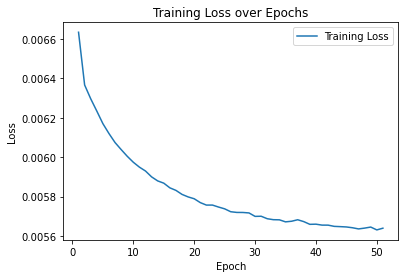

In [55]:
plt.plot(epochs, losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

In [59]:
result = test_sample_model(model, sample_matrix.T, device)

In [65]:
result_df = result[1]

In [67]:
# rows and columns that are not zero
result[0]

0.07575808385022091